In [6]:
import numpy as np
import sklearn
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
% matplotlib inline

import sys
print(sys.version_info)
print(np.__version__)

sys.version_info(major=3, minor=6, micro=1, releaselevel='final', serial=0)
1.12.1


In [7]:
n_input = 2

X, y = make_classification(n_samples=800, n_features=n_input, 
                           n_informative=n_input, n_redundant=0,
                           n_classes=2, n_clusters_per_class=1, 
                           random_state=42023)

In [8]:
n_input = 2
X, y = make_moons( n_samples=800, noise=0.2 )

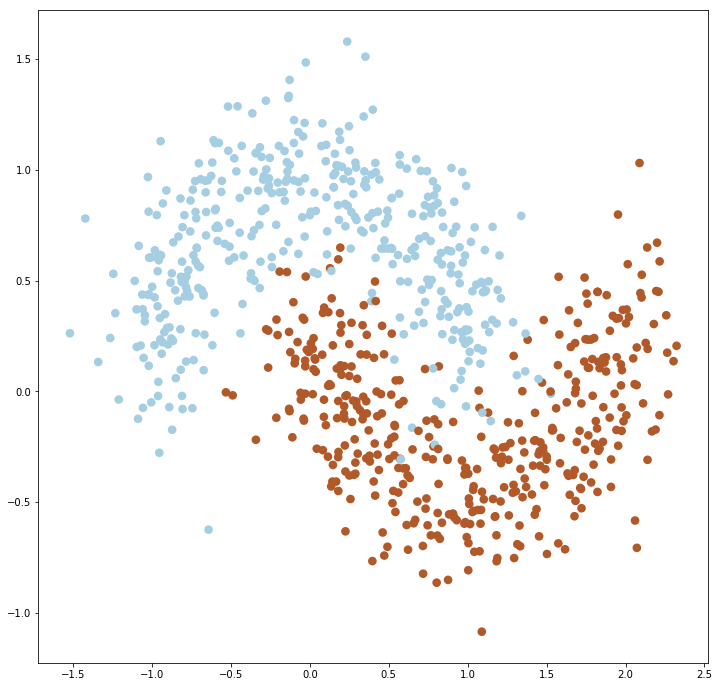

In [33]:
plt.figure(figsize=(12,12))
plt.scatter(X[:,0],X[:,1],c=y, s=75, linewidths=0, cmap=plt.cm.Paired)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42 )

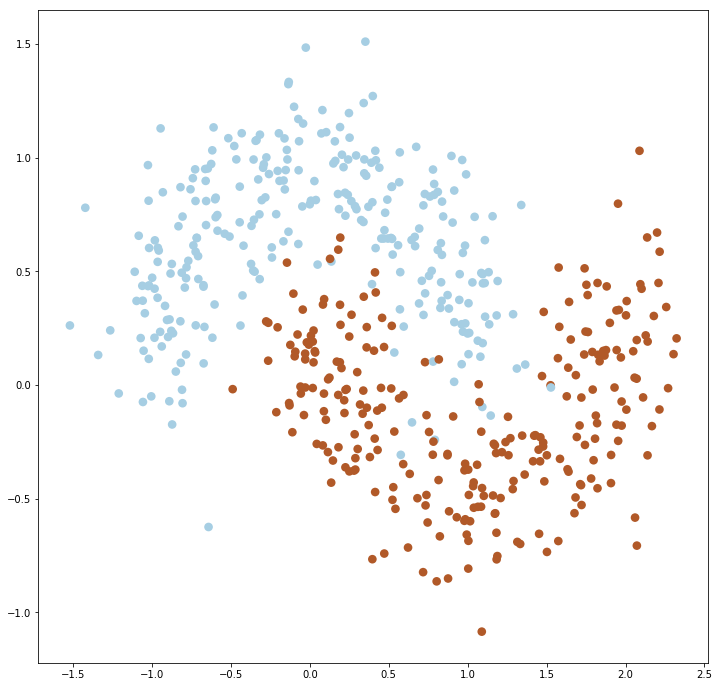

In [34]:
plt.figure(figsize=(12,12))
plt.scatter(X_train[:,0],X_train[:,1],c=y_train, s=75, linewidths=0, cmap=plt.cm.Paired)

In [12]:
n_hidden_neurons = [8,5]
n_hidden_layers = len(n_hidden_neurons)
nlayers = n_hidden_layers+2

In [15]:
class CrossEntropy():
        
    def error(self, y,a):
        return -y*np.log(a) - (1.-y)*np.log(1. - a)
    
    def derror(self,a, y):
        return a - y

In [16]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

In [17]:
class InputLayer():
    def __init__(self, n=2):
        self.z = np.zeros(shape=(n,1))
    def forward(self, x):
        self.z = x
        return x
    def last_activ(self):
        return self.z

In [18]:
class OutputLayer():
    def __init__(self, n=1, nprev=5, cost=CrossEntropy() ):
        self.N = n
        self.Nprev = nprev
        
        self.z = np.zeros(shape=(n,1))
        
        self.b = np.random.uniform(low=0., high=1., size=(n,1))
        self.bupdates = np.zeros_like(self.b)
        
        # W represents the matrix of weights from the PREVIOUS layer to THIS layer
        self.W = np.random.uniform(low=0., high=1., size=(n,nprev))
        self.Wupdates = np.zeros_like(self.W)
        
        self.cost_ = cost
        
    def forward(self, x):
        self.z = (self.W @ x).reshape(self.N,1) + self.b
        return sigmoid(self.z)
    
    def last_activ(self):
        return sigmoid(self.z)
    
    def backward(self, y):
        return self.cost_.derror(sigmoid(self.z),y)*sigmoid(self.z)*( 1.0 - sigmoid(self.z))
    
    def update(self):
        self.b -= self.bupdates
        self.W -= self.Wupdates

In [19]:
class SigmoidLayer():
    def __init__(self, n=5, nprev=5):
        self.N = n
        self.Nprev = nprev
        
        self.z = np.zeros(shape=(n,1))
        
        self.b = np.random.uniform(low=0., high=1., size=(n,1))
        self.bupdates = np.zeros_like(self.b)
        
        # W represents the matrix of weights from the PREVIOUS layer to THIS layer
        self.W = np.random.uniform(low=0., high=1., size=(n,nprev))
        self.Wupdates = np.zeros_like(self.W)
        
    def forward(self, x):
        self.z = np.dot(self.W,x).reshape(self.N,1) + self.b
        return sigmoid(self.z)
    
    def last_activ(self):
        return sigmoid(self.z)
    
    def backward(self, W, dLdz):
        '''Note: this W is NOT self.W, but the one from the downstream layer!'''
        return (W.T @ dLdz)*sigmoid(self.z)*(1. - sigmoid(self.z))
    
    def update(self):
        self.b -= self.bupdates
        self.W -= self.Wupdates

In [20]:
CostFunction = CrossEntropy()

In [21]:
layers = []
layers.append( InputLayer(n_input) )
nprev = n_input
for n in n_hidden_neurons:
    layers.append(SigmoidLayer(n, nprev))
    nprev = n
layers.append(OutputLayer(1,nprev,CostFunction))

In [23]:
# Ws[i] is between layers[i] and layers[i+1]
alpha = 0.1
n_epochs = 300

training_error = []
validation_error = []
    
for i in range(n_epochs):

    errors = []
    for idx, data_sample in enumerate(X_train):
        # feedforward
        a = layers[0].forward(data_sample)
        for i in range(1,nlayers):
            a = layers[i].forward(a)

        errors.append(CostFunction.error(y_train[idx], a))
    
        # backprop
        error = layers[nlayers-1].backward(y_train[idx])
        layers[nlayers-1].Wupdates = np.outer(error, layers[nlayers-2].last_activ() )
        layers[nlayers-1].bupdates = error
       
        for i in range(nlayers-2,0,-1):
            error = layers[i].backward(layers[i+1].W, error)
            layers[i].Wupdates = np.outer(error , layers[i-1].last_activ())
            layers[i].bupdates = error
            
        for i in range(1,nlayers):
            layers[i].update()
            
    training_error.append(np.mean(errors))
    
    # validation
    errors = []
    for idx, data_sample in enumerate(X_test):
        # feedforward
        a = layers[0].forward(data_sample)
        for i in range(1,nlayers):
            a = layers[i].forward(a)
        errors.append(CostFunction.error(y_test[idx], a[0]))
    validation_error.append(np.mean(errors))

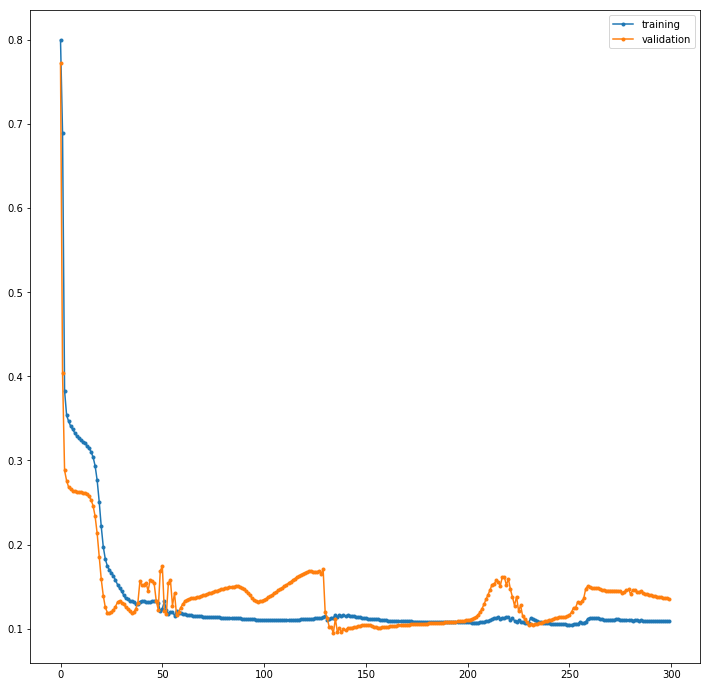

In [24]:
plt.figure(figsize=(12,12))
plt.plot(range(n_epochs), training_error, '.-')
plt.plot(range(n_epochs), validation_error, '.-')
plt.legend(['training','validation'])

In [26]:
def inference(layers, x):
    a = x
    for i in range(nlayers):
        a = layers[i].forward(a)
        
    return a > 0.5

In [28]:
print(inference(layers, np.array([3.5, -3.0]).reshape(2,1)))
print(inference(layers, np.array([-2.0, 2.0]).reshape(2,1)))

[[ True]]
[[False]]


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.]
1


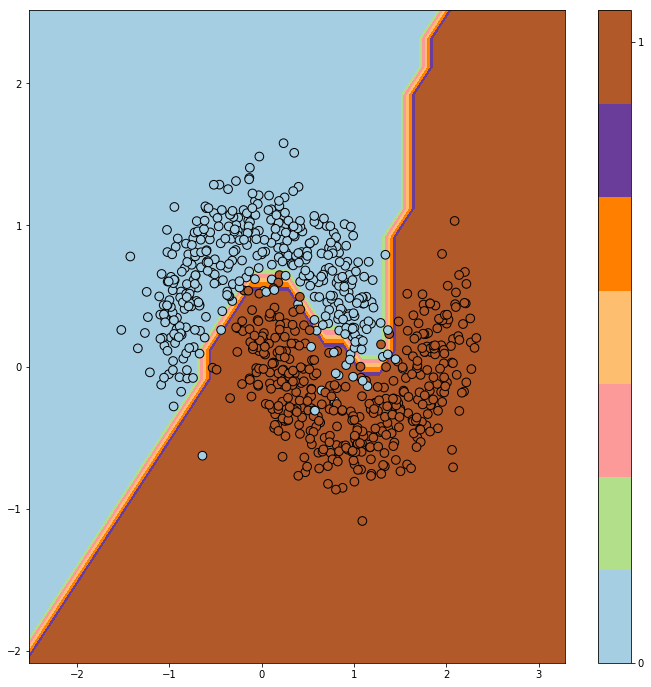

In [48]:
h=0.2
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = np.zeros_like(xx)

# here "model" is your model's prediction (classification) function
for ix, x in enumerate(xx[0,:]):
    for iy, yv in enumerate(yy[:,0]):
        Z[iy,ix] = inference(layers, np.r_[x, yv])[0]


print(Z[-1])
print(y[0])

# Put the result into a color plot
#Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,12))
plt.contourf(xx, yy, Z, LevelStep=1, cmap=plt.cm.Paired)
plt.colorbar(ticks=[-1,0,1])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=75, linewidth=1,  edgecolor='black')